In [83]:
"""
Input:  Training Data
        X_positive, Y_positive, X_negative, Y_negative
Output: Objectness Model and Heatmap of Objectness scores
        
The aim of this code is train a convolutional neural network as regressor for objectness scores.
"""

'\nInput:  Training Data\n        X_positive, Y_positive, X_negative, Y_negative\nOutput: Objectness Model and Heatmap of Objectness scores\n        \nThe aim of this code is train a convolutional neural network as regressor for objectness scores.\n'

In [82]:
import cv2
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import argparse
import locale
import os
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
#Hyperparameters
input_shape = (64,64,1)
IMG_SIZE = 64

In [3]:
#Get Data 
X_positive= np.load("X_positive.npy")
Y_positive= np.load("Y_positive.npy")
X_negative= np.load("X_negative.npy")
Y_negative= np.load("Y_negative.npy")

In [4]:
#Random Selection of Negative data points
n = 79645  # for 2 random indices
index = np.random.choice(X_negative.shape[0], n, replace=False)
X_negative = X_negative[index]
Y_negative = Y_negative[index]

In [5]:
#Total Data
X = list(X_positive) + list(X_negative)
Y = list(Y_positive) + list(Y_negative)
X = np.asarray(X)
Y = np.asarray(Y)

In [6]:
(X.shape, Y.shape)

((159290, 64, 64), (159290,))

In [7]:
#Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [8]:
#Change shape to 64,64,1
X_train= X_train.reshape(X_train.shape[0],IMG_SIZE,IMG_SIZE,1)
validate_x = X_test.reshape(X_test.shape[0],IMG_SIZE,IMG_SIZE,1)

In [9]:
validate_x.shape

(52566, 64, 64, 1)

In [10]:
#ObjectNess model
ObjectNessModel= Sequential()

ObjectNessModel.add(Conv2D(32, kernel_size=(5, 5), input_shape=input_shape, use_bias=False))
ObjectNessModel.add(BatchNormalization())
ObjectNessModel.add(Activation("relu"))
ObjectNessModel.add(MaxPooling2D(pool_size=(2, 2)))

ObjectNessModel.add(Conv2D(32, kernel_size=(5, 5), use_bias=False))
ObjectNessModel.add(BatchNormalization())
ObjectNessModel.add(Activation("relu"))
ObjectNessModel.add(MaxPooling2D(pool_size=(2, 2)))

ObjectNessModel.add(Flatten())

ObjectNessModel.add(Dense(64, use_bias=False))
ObjectNessModel.add(BatchNormalization())
ObjectNessModel.add(Activation("relu"))

ObjectNessModel.add(Dense(1, activation='sigmoid'))
ObjectNessModel.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        25600     
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 32)      

In [11]:
#Compile the model
ObjectNessModel.compile(loss="mean_squared_error", optimizer=Adam(lr=0.1))

In [12]:
#Model Training
ObjectNessModel.fit(X_train, y_train, validation_data=(validate_x, y_test), epochs=10,verbose=1)


Train on 106724 samples, validate on 52566 samples
Epoch 1/10
106724/106724 [==============================] - 40s 379us/step - loss: 0.0073 - val_loss: 0.0038
Epoch 2/10
106724/106724 [==============================] - 40s 375us/step - loss: 0.0045 - val_loss: 0.0037
Epoch 3/10
106724/106724 [==============================] - 40s 375us/step - loss: 0.0039 - val_loss: 0.0029
Epoch 4/10
106724/106724 [==============================] - 40s 375us/step - loss: 0.0035 - val_loss: 0.0027
Epoch 5/10
106724/106724 [==============================] - 40s 375us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 6/10
106724/106724 [==============================] - 40s 376us/step - loss: 0.0032 - val_loss: 0.0022
Epoch 7/10
106724/106724 [==============================] - 40s 376us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/10
106724/106724 [==============================] - 40s 376us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 9/10
106724/106724 [==============================] - 40s 376us/step -

In [46]:
#Prediction of ObjectNess
image = cv2.imread("Positive/Positive_pipe_1367.jpg", cv2.IMREAD_GRAYSCALE)
image = image.reshape(1,IMG_SIZE,IMG_SIZE,1)
ObjectNessModel.predict(image)[0][0]

0.61942303

In [58]:
image = cv2.imread("Images/image0.jpg", cv2.IMREAD_GRAYSCALE)

In [57]:
heatmap=[]
w_width = 64
w_height = 64

In [66]:
row=[]
for x in range(0, image.shape[1] - w_width):
    column=[]
    for y in range(0, image.shape[0] - w_height):
        crop_img = image[y:y+w_height, x:x+w_width]
        crop_img = crop_img.reshape(1,IMG_SIZE,IMG_SIZE,1)
        column.append(ObjectNessModel.predict(crop_img)[0][0])
    row.append(column)

In [67]:
np.save("heatmap.npy", row)

In [61]:
ObjectNessModel.save("ObjectNessModel.h5")

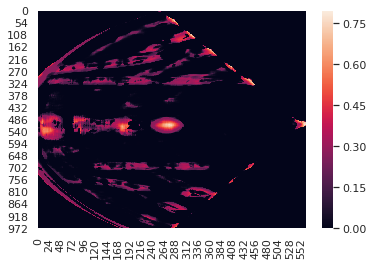

In [68]:
import numpy as np
import seaborn as sns
sns.set()
ax = sns.heatmap(row)

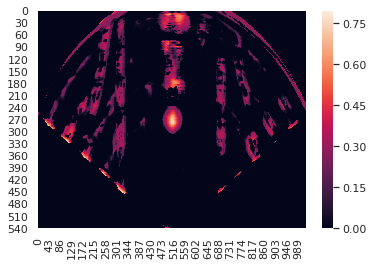

In [81]:
sns.set()
heatmap = np.asarray(row).transpose()
ax = sns.heatmap(heatmap)
# Saving image
plt.savefig('heatmap-01.png')
# In case you dont want to save image but just displya it
plt.show()

In [74]:
new = np.asarray(row).transpose()

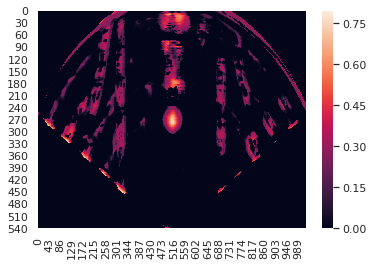

In [75]:
ax = sns.heatmap(new)

In [76]:
new = new>0.6

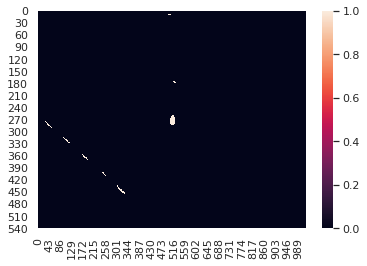

In [77]:
ax = sns.heatmap(new)